In [360]:
import pyabc
import scipy
import numpy as np
from pyabc.visualization import plot_kde_matrix_highlevel,plot_kde_matrix2
from datetime import datetime
import pandas as pd
from arviz import hdi
from pyabc.visualization import plot_kde_matrix_highlevel, plot_kde_matrix

output_path = '../../figures'
path = '/Users/adsurbum/sim-data/single-model-abc/new4'
f_with_aneuploidy = '2021-12-29-an200-k1'

In [ ]:
## Instruction
### You can jump [loading section](#loading) if you want only to plot figure and the data is already persisted

In [5]:
def MAP(f):
    history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, f))
    samples, weights = history.get_distribution(m=0, t=None)
    columns = list(samples.columns)
    kde = scipy.stats.gaussian_kde(samples.T.values.tolist(), weights=weights)
    size = 50000
    samples = kde.resample(size).T
    samples = pd.DataFrame(data=samples,columns=columns)
    MAP = scipy.optimize.minimize(lambda x: -kde.logpdf(x) ,samples.median().values)['x']
    return MAP

map_params =MAP(f_with_aneuploidy)
map_params

array([2.93858855e-06, 1.72573895e-03, 1.02216171e+00, 1.02473173e+00,
       1.02789362e+00])

In [323]:
%%time

def construct_space(bounds, center):
    # (l1,l2) bounds
    # (s,e) most points
    l1, l2 = bounds
    s, e = center
    sbefore = np.logspace(np.log10(l1), np.log10(s),5)
    smiddle = np.logspace(np.log10(s),np.log10(e),12)
    safter = np.logspace(np.log10(e), np.log10(l2),5)
    return np.concatenate((sbefore[:-1], smiddle[1:], safter[1:]))

import sys  
sys.path.insert(0, '../models')
from singleLocusModel import SingleLocusModel
model = SingleLocusModel(k=1)
N = 6*10**6
reps = 1000

params = [map_params[0],map_params[1],map_params[1],*map_params[2:]] #aneuplloidy gane and loss are the same

times_p = model.run_simulations(*[N,*params] , repetitions=reps,seed=123)
g = model.grade_function(times_p)


CPU times: user 36.1 s, sys: 587 ms, total: 36.7 s
Wall time: 39.5 s


In [363]:
import matplotlib.pyplot as plt
sns.set()
# sns.set(font_scale=1.5, rc={"lines.linewidth": 2.5, 'lines.markersize': 8})
sns.set(style="ticks",context='talk' ,rc={"lines.linewidth": 1.5, 'lines.markersize': 4})

from operator import itemgetter
def replace(arr,i,e):
    arr = list(arr) #for tuples
    ans = arr[:i]+[e]+arr[i+1:]
    return ans

def calculateGrades(default, i, rangee, reps, defaultGrade, points,seed=20):
    if type(i) is not list:
        i = [i]
    grades = [] 
    for r in rangee:
        params = list(default)
        for j in i:
            params = replace(params,j,r)
        times_p = model.run_simulations(*params, repetitions=reps,seed=seed)
        grade = model.grade_function(times_p)
        grades.append((r,-grade+0.01))
    
    defGrade = (default[i[0]], defaultGrade)
    grades.append((default[i[0]], defaultGrade))
    
    grades.sort(key=itemgetter(0))
    
    return (grades, defGrade)

def plotGrades(xlabel, gg, letter, x_log_scale=True, showylabel=False):
#     grades,defaultGrade,pointGrades = gg # now we don't have pointGrades
    grades, defaultGrade = gg
    plt.plot(list(zip(*grades))[0], list(zip(*grades))[1], '-o', color='black')
    
#     plt.plot(defaultGrade[0], defaultGrade[1], 'ro', label=str(round(defaultGrade[0],3))+' - best fit')
    
    plt.axvline(defaultGrade[0],linestyle='--',linewidth=1, color="black")

    plt.xlabel(xlabel)
    if showylabel:
        plt.ylabel('Approximate likelihood')

    plt.yscale('log')
    if x_log_scale:
         plt.xscale('log')
        
    ax = plt.gca()
    ax.text(-0.1, 1.05, letter, transform=ax.transAxes, size=20, weight='bold')
    plt.gcf().savefig(f'{output_path}/sensitivity-{letter}.pdf', bbox_inches='tight')
    plt.show()

In [324]:
space = construct_space((1e-9, 1e-5), (6e-7, 1e-5)) 
mu_grades = calculateGrades([N,*params], 1, space, reps, -g, [], seed=123)

In [326]:
space = construct_space((1e-6, 1e-2), (2e-4, 1e-2))
lambda_grades = calculateGrades([N,*params], [2,3], space, reps, -g, [], seed=123) #gain and loss replace together

In [328]:
space = construct_space((1.02, 1.025), (1.0215, 1.023))
w_anwt = calculateGrades([N,*params], 4, space, reps, -g, [], seed=123);


In [330]:
space = construct_space((1.01, 1.04), (1.021, 1.032))
w_anmt = calculateGrades([N,*params], 5, space, reps, -g, [], seed=123);

In [332]:
# space = np.logspace(np.log10(1.026),np.log10(1.029),18)
space = construct_space((1.025, 1.031), (1.027, 1.0285))
w_eumt = calculateGrades([N,*params], 6, space, reps, -g, [], seed=123);


In [339]:
# np.savez('./outputs/sensitivity',mu_grades=mu_grades, 
#                      lambda_grades=lambda_grades, w_anwt=w_anwt, w_anmt=w_anmt, w_eumt=w_eumt)

In [349]:
load = np.load('./outputs/sensitivity.npz',allow_pickle=True)
mu_grades, lambda_grades, w_anwt, w_anmt, w_eumt = load['mu_grades'], load['lambda_grades'], load['w_anwt'], load['w_anmt'], load['w_eumt']

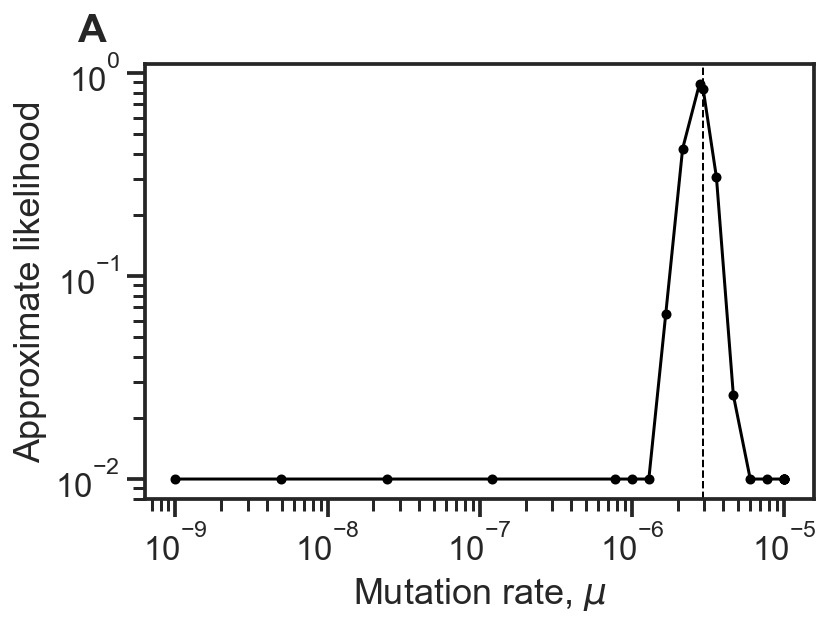

In [364]:
plotGrades('Mutation rate, $\mu$', mu_grades, letter='A', x_log_scale=True, showylabel=True)

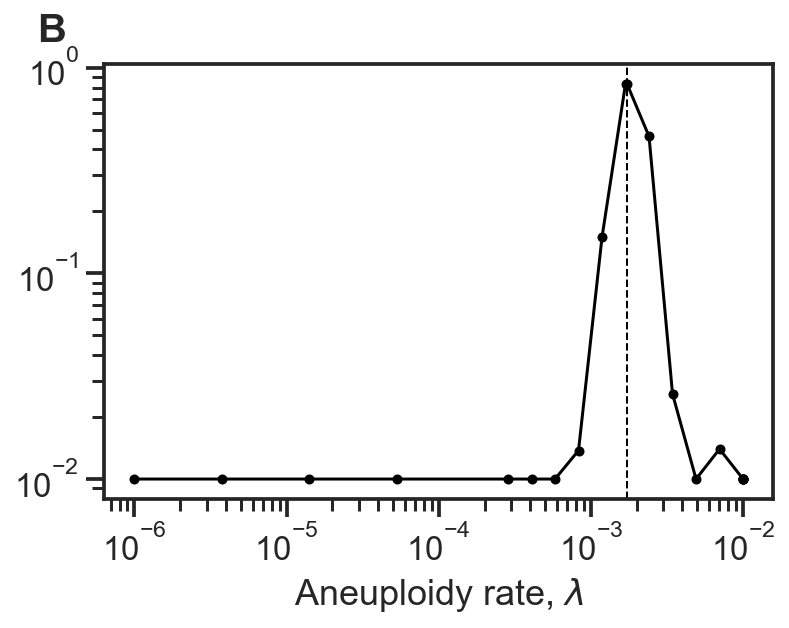

In [365]:
plotGrades('Aneuploidy rate, $\lambda$', lambda_grades, letter='B', x_log_scale=True, showylabel=False)

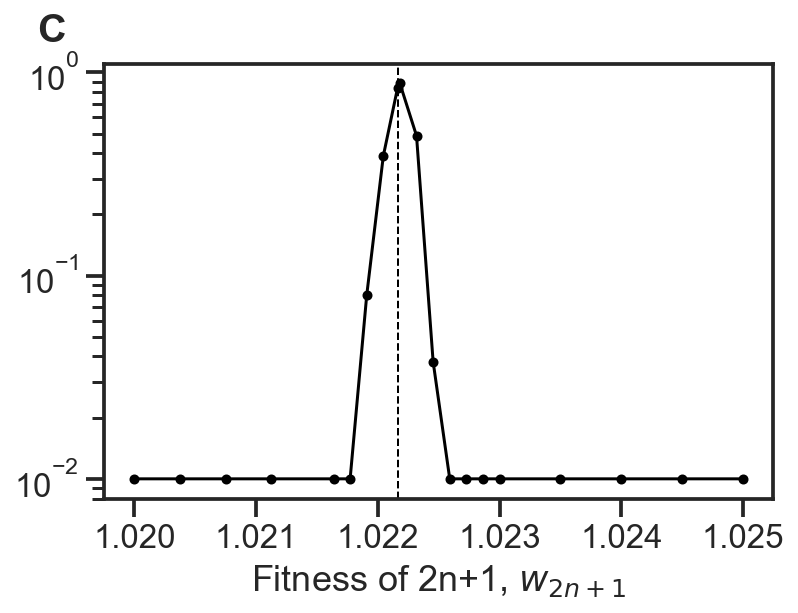

In [366]:
plotGrades('Fitness of 2n+1, $w_{2n+1}$', w_anwt, letter='C', x_log_scale=False, showylabel=False)

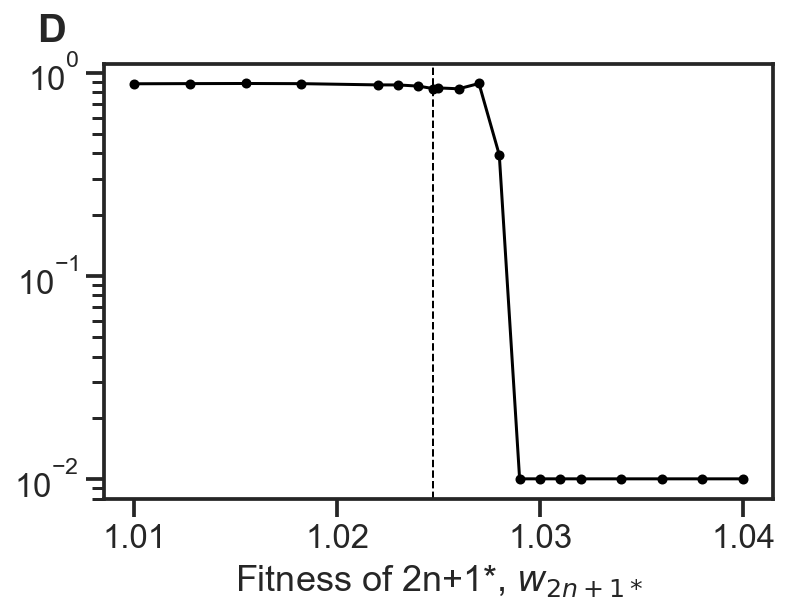

In [367]:
plotGrades('Fitness of 2n+1*, $w_{2n+1*}$', w_anmt, letter='D', x_log_scale=False, showylabel=False)

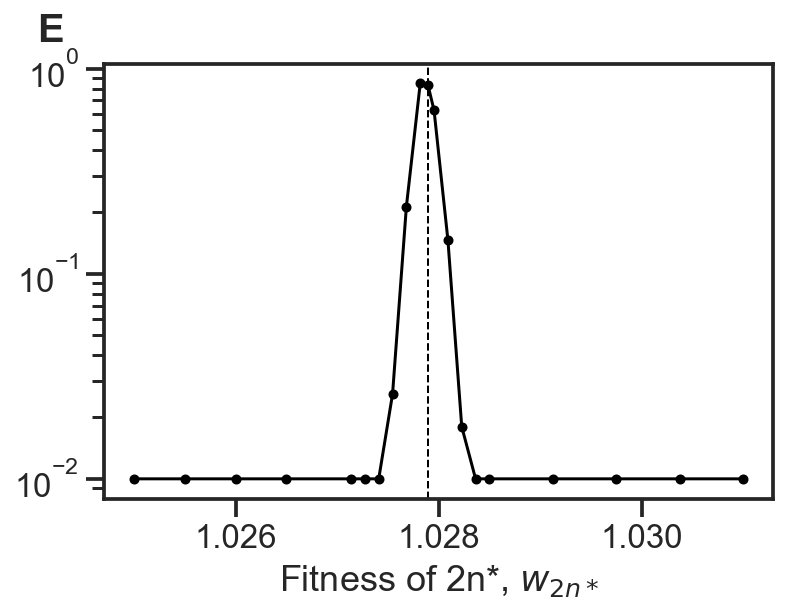

In [368]:
plotGrades('Fitness of 2n*, $w_{2n*}$', w_eumt, letter='E', x_log_scale=False, showylabel=False)